# 讀取MNIST資料

In [13]:
!pip install tensorflow-addons
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
from tensorflow.keras.datasets import mnist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


# 取出25張測試資料集圖片

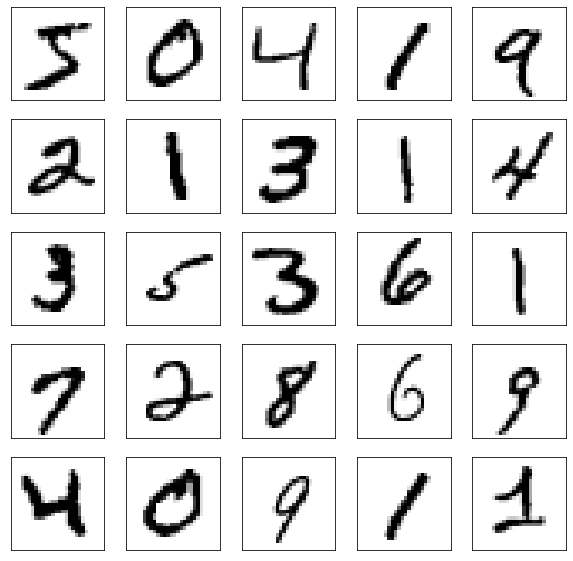

In [2]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[i], cmap="binary")
plt.show()

# 資料預處理
* np.expand_dims將shape修改為(樣本數,圖片寬,圖片高,通道數)彩色為3，灰色為1
* Normalize圖片RGB由255降到0-1間

In [3]:
img_size = X_train.shape[1]
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train = X_train / 255
X_test = X_test / 255

# 建立模型

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
cnn = Sequential()
cnn.add(Conv2D(filters=1024, kernel_size=(3,3), activation='relu', input_shape=(img_size, img_size, 1)))
cnn.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
cnn.add(MaxPool2D(pool_size=(2,2), strides=2))
cnn.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
cnn.add(MaxPool2D(pool_size=(2,2), strides=2))
cnn.add(Dropout(0.2))
cnn.add(Flatten())
cnn.add(Dense(units=128, activation='relu'))  #Param=6400*128+128=819328
cnn.add(Dense(units=10, activation='softmax')) #Param=128*10+10=1290
#cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn.compile(optimizer=tfa.optimizers.RectifiedAdam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 1024)      10240     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 512)       4719104   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 512)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 256)       1179904   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 256)         0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0

# 設定儲存最佳模型參數、提早停止模型訓練、儲存History

In [5]:
import os
model_dir = '/content/drive/MyDrive/Colab Notebooks/MNIST'
if not os.path.exists(model_dir):
  os.makedirs(model_dir)
modelfiles = model_dir + '/MNIST-best-model.h5'
model_chpo = keras.callbacks.ModelCheckpoint(modelfiles, monitor='val_accuracy', save_best_only=True)
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)
csv_logger = keras.callbacks.CSVLogger(model_dir+"/MNIST_training.log")
callbacks_list = [model_chpo, earlystop, csv_logger]

# 訓練模型

In [6]:
batch_size, epochs = 128, 100
cnn.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
    validation_data=(X_test, y_test), callbacks=callbacks_list)

Epoch 1/100
1875/1875 [==============================] - 118s 60ms/step - loss: 0.3565 - accuracy: 0.8916 - val_loss: 0.0386 - val_accuracy: 0.9867
Epoch 2/100
1875/1875 [==============================] - 112s 60ms/step - loss: 0.0496 - accuracy: 0.9847 - val_loss: 0.0337 - val_accuracy: 0.9897
Epoch 3/100
1875/1875 [==============================] - 112s 60ms/step - loss: 0.0319 - accuracy: 0.9901 - val_loss: 0.0345 - val_accuracy: 0.9893
Epoch 4/100
1875/1875 [==============================] - 112s 60ms/step - loss: 0.0249 - accuracy: 0.9920 - val_loss: 0.0390 - val_accuracy: 0.9887
Epoch 5/100
1875/1875 [==============================] - 112s 60ms/step - loss: 0.0174 - accuracy: 0.9942 - val_loss: 0.0302 - val_accuracy: 0.9919
Epoch 6/100
1875/1875 [==============================] - 112s 60ms/step - loss: 0.0127 - accuracy: 0.9960 - val_loss: 0.0274 - val_accuracy: 0.9921
Epoch 7/100
1875/1875 [==============================] - 112s 60ms/step - loss: 0.0110 - accuracy: 0.9965 - val_

In [7]:
val, accuracy = cnn.evaluate(X_test, y_test)
print(f"損失Loss: {val:.4f}\n評估模型準確度: {accuracy:.4f}")

313/313 [==============================] - 5s 17ms/step - loss: 0.0241 - accuracy: 0.9947
損失Loss: 0.0241
評估模型準確度: 0.9947


In [9]:
pre = cnn.predict_classes(X_test)
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, pre))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


,0,1,2,3,4,5,6,7,8,9
0,979,0,0,0,0,0,0,1,0,0
1,0,1134,0,0,0,1,0,0,0,0
2,0,2,1020,1,0,0,1,6,2,0
3,0,0,0,1003,0,6,0,0,1,0
4,0,0,0,0,980,0,0,0,0,2
5,0,0,0,2,0,889,1,0,0,0
6,3,1,0,0,1,3,949,0,1,0
7,0,4,0,0,0,0,0,1022,1,1
8,0,0,1,1,0,0,0,0,971,1
9,0,0,1,0,4,2,0,2,0,1000


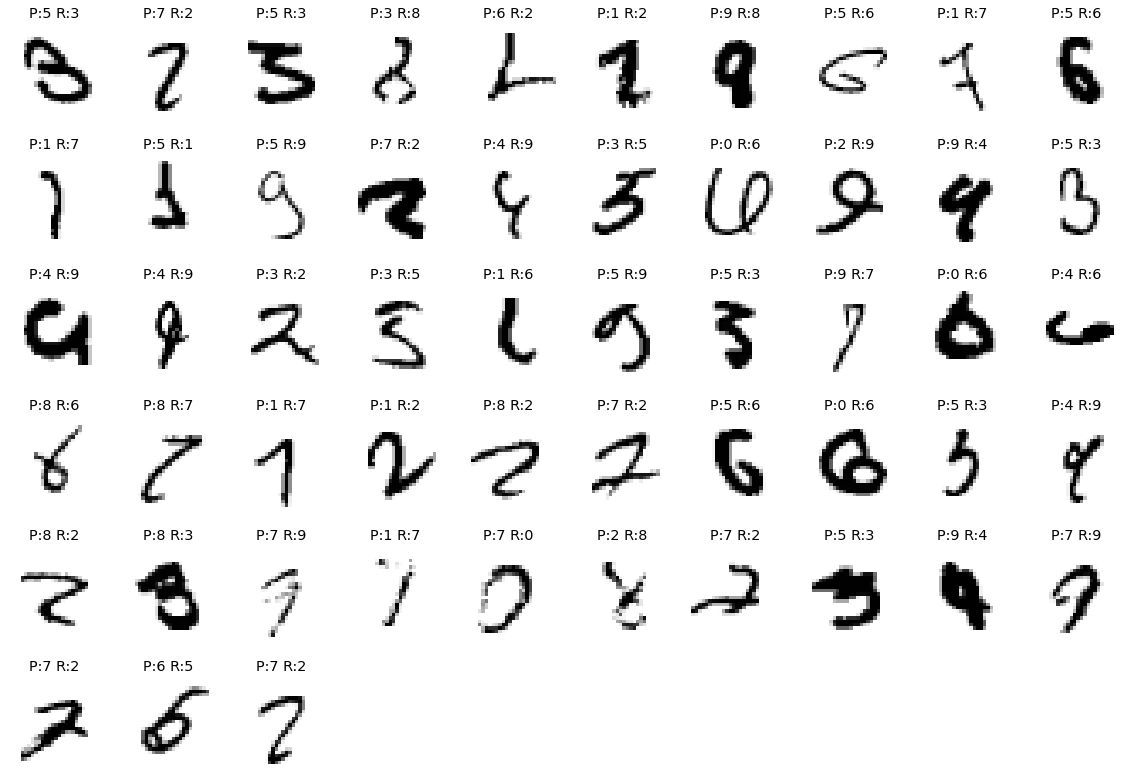

In [47]:
import numpy as np
wrong_list = np.nonzero(pre != y_test)[0] #預測錯誤列表
right_lable = y_test[wrong_list] #預測錯誤圖片的正確標籤
pre_lable = pre[wrong_list] #預測錯誤圖片的預測標籤
wrong_img = X_test[wrong_list] #錯誤圖片

plt.figure(figsize=(20,14))
width = 10
height = int(len(wrong_img)/10) + 1
for i, img in enumerate(wrong_img):
  plt.subplot(height, width, i+1)
  plt.axis("off")
  title = f"P:{pre_lable[i]} R:{right_lable[i]}"
  plt.title(title)
  plt.imshow(img, cmap="binary")

# 繪製Training圖表

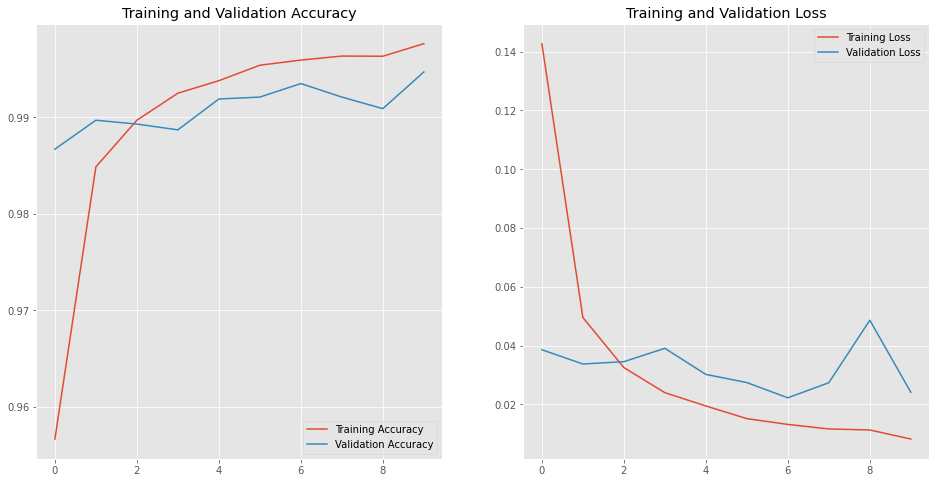

In [11]:
def plot_accuracy_loss(file_name):
    import pandas as pd
    log_data = pd.read_csv(file_name)
    acc = log_data['accuracy']
    val_acc = log_data['val_accuracy']
    loss = log_data['loss']
    val_loss = log_data['val_loss']
    import matplotlib.pyplot as plt
    plt.style.use('ggplot')
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(log_data['epoch'], acc, label='Training Accuracy')
    plt.plot(log_data['epoch'], val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(log_data['epoch'], loss, label='Training Loss')
    plt.plot(log_data['epoch'], val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    return plt.show()
plot_accuracy_loss("/content/drive/MyDrive/Colab Notebooks/MNIST/MNIST_training.log")

# 模型預測
* 不重新訓練模型預測，請先執行cell_1然後執行下方第一格。
* 執行上述過程後，即可直接使用下方第二格進行預測分析。

In [ ]:
cnn = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/MNIST/MNIST-best-model.h5")

預測分類: 2


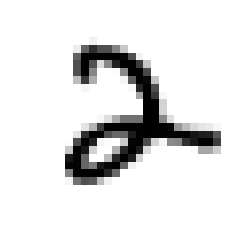

In [22]:
from random import randint
num_random = randint(0,X_train.shape[0]-1)
test_imp = np.expand_dims(X_train[num_random]/255,axis=0)
test_imp = np.expand_dims(test_imp,axis=-1)
pred = cnn.predict(test_imp)
print(f"預測分類: {range(0,10)[np.argmax(pred)]}")
plt.xticks([])
plt.yticks([])
plt.imshow(X_train[num_random], cmap="binary")